In [1]:
import torch
import numpy as np
import torchvision
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class AE(torch.nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, input_shape),
            torch.nn.Sigmoid()
        )
        
    def forward(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

In [3]:
class CAE(torch.nn.Module):
    def __init__(self, input_shape):
        super(CAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 4, kernel_size=3, padding=1),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU())
 
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(4, 16, 2, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 2, stride=2),
            torch.nn.Sigmoid())
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform)

train_set, test_set = random_split(train_dataset, (48000, 12000))

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False)

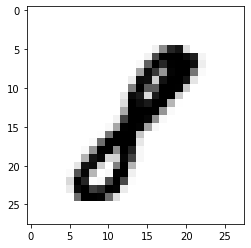

In [5]:
plt.imshow(train_set[0][0].reshape((28,28)), cmap='Greys')

In [6]:
conv_model = CAE(input_shape = 784)

In [7]:
lin_model = AE(input_shape = 784)

In [8]:
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
lin_optimizer = torch.optim.Adam(lin_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [9]:
def train(model, train_loader, optimizer, loss_fn, epochs):
    loss_list = []
    for epoch in range(epochs):
        loss = 0
        for inputs, targets in train_loader:
            if model.__class__.__name__ == 'AE':
                inputs = inputs.view(-1, 784)
            #reser gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(inputs)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, inputs)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
            
        #compute the epoch training loss
        loss = loss/len(train_loader)
        loss_list.append(loss)
        #print info
        if epoch%10 == 9 or epoch == 0:
            print('Epoch {} of {}, loss={:.3}'.format(epoch+1, epochs, loss))
    return loss_list

In [10]:
loss_list = train(conv_model, train_loader, conv_optimizer, loss_fn, 100)

Epoch 1 of 100, loss=0.11
Epoch 10 of 100, loss=0.0107
Epoch 20 of 100, loss=0.00954
Epoch 30 of 100, loss=0.00907
Epoch 40 of 100, loss=0.0089
Epoch 50 of 100, loss=0.00878
Epoch 60 of 100, loss=0.00869
Epoch 70 of 100, loss=0.00861
Epoch 80 of 100, loss=0.00856
Epoch 90 of 100, loss=0.00851
Epoch 100 of 100, loss=0.00847


In [11]:
loss_list_linear = train(lin_model, train_loader, lin_optimizer, loss_fn, 100)

Epoch 1 of 100, loss=0.0478
Epoch 10 of 100, loss=0.00697
Epoch 20 of 100, loss=0.00535
Epoch 30 of 100, loss=0.00476
Epoch 40 of 100, loss=0.00447
Epoch 50 of 100, loss=0.00426
Epoch 60 of 100, loss=0.00412
Epoch 70 of 100, loss=0.004
Epoch 80 of 100, loss=0.00392
Epoch 90 of 100, loss=0.00385
Epoch 100 of 100, loss=0.0038


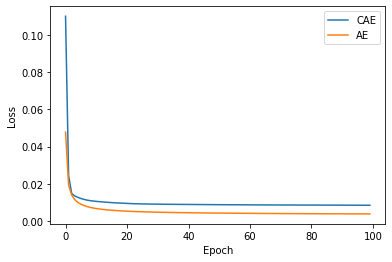

In [17]:
plt.plot(range(len(loss_list)), loss_list, label='CAE')
plt.plot(range(len(loss_list_linear)), loss_list_linear, label='AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
def draw_samples(data_set, model, file_name):
    fig, ax = plt.subplots(2,9, figsize=(20,5))
    for i in range(9):
        num = random.randint(0,len(data_set))
        if model.__class__.__name__ == 'AE':
            out = model(data_set[num][0].view(-1, 784))
        else:
            out = model(data_set[num][0].unsqueeze(0))
        out = out/out.max().item()
        out = out.view(28,28)
        ax[0][i].imshow(data_set[num][0].reshape((28,28)), cmap='Greys_r')
        ax[0][i].set_axis_off()
        ax[1][i].imshow(out.detach(), cmap='Greys_r')
        ax[1][i].set_axis_off()
        if i%9 == 4:
            ax[0][i].set_title('Original', size=20)
            ax[1][i].set_title('Reconstructed', size=20)
        plt.subplots_adjust(wspace = 0, hspace = 0.2)

    plt.show()
    fig.savefig(file_name, dpi=300)

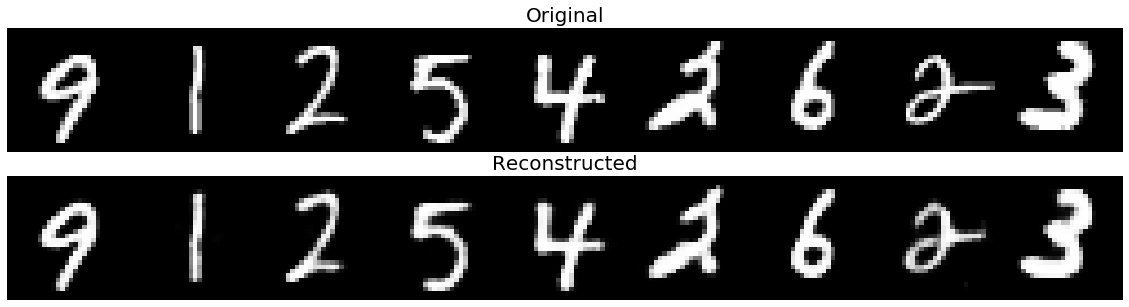

In [22]:
draw_samples(test_set, lin_model, file_name='Linear_AE.png')

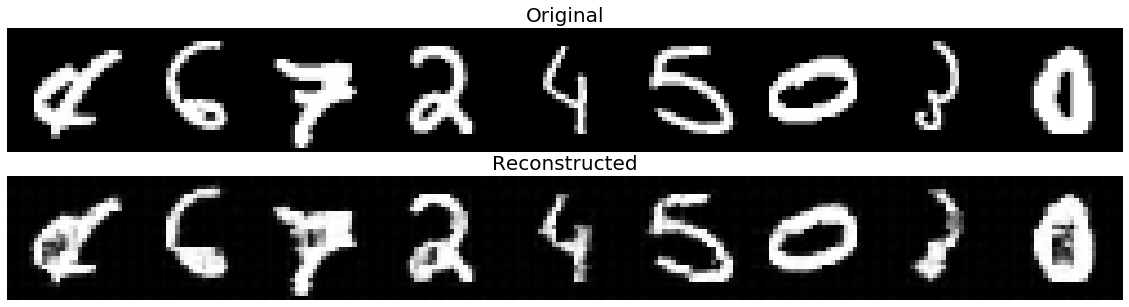

In [23]:
draw_samples(test_set, conv_model, file_name='Conv_AE.png')